# Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torchsom.core import TorchSOM
from torchsom.plotting import SOMVisualizer, VisualizationConfig

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing 

In [3]:
energy_df = pd.read_csv(
    filepath_or_buffer="../data/energy_efficiency.csv",
)

In [4]:
# energy_df_scaled = energy_df
scaler = StandardScaler()
energy_df_scaled = pd.DataFrame(scaler.fit_transform(energy_df), columns=energy_df.columns)

In [5]:
energy_df_scaled.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.341641,-1.760447,-1.814575,-0.670115,-0.342666
1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-0.447214,-1.760447,-1.814575,-0.670115,-0.342666
2,2.041777,-1.785875,-0.561951,-1.470077,1.0,0.447214,-1.760447,-1.814575,-0.670115,-0.342666
3,2.041777,-1.785875,-0.561951,-1.470077,1.0,1.341641,-1.760447,-1.814575,-0.670115,-0.342666
4,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.341641,-1.760447,-1.814575,-0.145503,0.388366


In [6]:
energy_df_scaled.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,7.680000e+02,7.680000e+02,768.000000,7.680000e+02,768.000000,768.000000,7.680000e+02,768.000000,7.680000e+02,7.680000e+02
mean,-7.401487e-17,-4.163336e-16,0.000000,2.174187e-16,0.000000,0.000000,1.480297e-16,0.000000,7.401487e-17,-2.035409e-16
std,1.000652e+00,1.000652e+00,1.000652,1.000652e+00,1.000652,1.000652,1.000652e+00,1.000652,1.000652e+00,1.000652e+00
min,-1.363812e+00,-1.785875e+00,-1.685854,-1.470077e+00,-1.000000,-1.341641,-1.760447e+00,-1.814575,-1.616203e+00,-1.439739e+00
25%,-7.725642e-01,-7.421818e-01,-0.561951,-7.915797e-01,-1.000000,-0.670820,-1.009323e+00,-0.685506,-9.237440e-01,-9.432688e-01
50%,-1.340162e-01,2.319318e-02,0.000000,1.583159e-01,0.000000,0.000000,1.173631e-01,0.120972,-3.329351e-01,-2.637774e-01
75%,6.227813e-01,7.885681e-01,0.561951,9.725122e-01,1.000000,0.670820,1.244049e+00,0.766154,9.282671e-01,8.987736e-01
max,2.041777e+00,1.553943e+00,2.247806,9.725122e-01,1.000000,1.341641,1.244049e+00,1.411336,2.062035e+00,2.465759e+00


In [7]:
feature_names = energy_df_scaled.columns.to_list()[:-2]
feature_names

['Relative Compactness',
 'Surface Area',
 'Wall Area',
 'Roof Area',
 'Overall Height',
 'Orientation',
 'Glazing Area',
 'Glazing Area Distribution']

In [8]:
energy_df_scaled.shape

(768, 10)

In [9]:
"""
1. Create a tensor from the energy df and separate the features and the target
2. Randomly shuffle the data
3. Split the data into training and testing sets
"""
energy_torch = torch.tensor(energy_df_scaled.to_numpy(dtype=np.float32))
all_features = energy_torch[:, :-2]
all_targets_heating, all_targets_cooling = energy_torch[:, -2], energy_torch[:, -1]

shuffled_indices = torch.randperm(len(all_features))
all_features = all_features[shuffled_indices]
all_targets_heating, all_targets_cooling = all_targets_heating[shuffled_indices], all_targets_cooling[shuffled_indices]

train_ratio = 0.8
train_count = int(train_ratio * len(all_features))

train_features = all_features[:train_count]
train_targets_heating, train_targets_cooling = all_targets_heating[:train_count], all_targets_cooling[:train_count]

test_features = all_features[train_count:]
test_targets_heating, test_targets_cooling = all_targets_heating[train_count:], all_targets_cooling[train_count:]

print(train_features.shape, test_features.shape)
print(train_targets_heating.shape, train_targets_cooling.shape, test_targets_heating.shape, test_targets_cooling.shape)

torch.Size([614, 8]) torch.Size([154, 8])
torch.Size([614]) torch.Size([614]) torch.Size([154]) torch.Size([154])


# TorchSOM

In [10]:
som = TorchSOM(
    x=35,
    y=20,
    sigma=2.5,
    learning_rate=0.95,
    neighborhood_order=3,
    epochs=125,
    batch_size=16,
    topology="rectangular",
    distance_function="euclidean",
    neighborhood_function="gaussian",
    num_features=all_features.shape[1],
    lr_decay_function="asymptotic_decay",
    sigma_decay_function="asymptotic_decay",
    initialization_mode="pca",
    device=device,
    random_seed=random_seed,
) 

In [11]:
som.initialize_weights(
    data=train_features,
)

In [12]:
QE, TE = som.fit(
    data=train_features
)

Training SOM: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.08epoch/s]


In [13]:
visualizer = SOMVisualizer(som=som, config=None)
save_path = "results/energy" # Set to None if you want a direct plot

In [14]:
visualizer.plot_training_errors(
    quantization_errors=QE, 
    topographic_errors=TE, 
    save_path=save_path
)

In [15]:
visualizer.plot_distance_map(save_path=save_path)

In [16]:
visualizer.plot_hit_map(
    data=train_features,
    save_path=save_path
)

In [17]:
visualizer.plot_component_planes(
    component_names=feature_names,
    save_path=save_path
)

### Heating Target

In [18]:
heating_path = save_path + "/heating"

In [19]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets_heating, 
    reduction_parameter="mean",
    save_path=heating_path,
)

In [20]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets_heating,
    reduction_parameter="std",
    save_path=heating_path,
)

In [21]:
visualizer.plot_rank_map(
    data=train_features,
    target=train_targets_heating,
    save_path=heating_path
)

In [22]:
visualizer.plot_score_map(
    data=train_features,
    target=train_targets_heating,
    save_path=heating_path,
)

### Cooling Target

In [23]:
cooling_path = save_path + "/cooling"

In [24]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets_cooling,
    reduction_parameter="mean",
    save_path=cooling_path,
)

In [25]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets_cooling,
    reduction_parameter="std",
    save_path=cooling_path,
)

In [26]:
visualizer.plot_rank_map(
    data=train_features,
    target=train_targets_cooling,
    save_path=cooling_path
)

In [27]:
visualizer.plot_score_map(
    data=train_features,
    target=train_targets_cooling,
    save_path=cooling_path,
)

# Prediction of the Heating Target
Here, we do not add the testing samples in the SOM BMUs map.  
In forecasting or process control, it is interesting to add overtime the new elements in the SOM and potentially to update/refit it with a certain frequency.

In [28]:
predictions = []
bmus_idx_map = som.build_bmus_data_map(
    data=train_features,
    return_indices=True,  # False means we want the features of each sample and not the indices
)
for idx, (test_feature, test_target) in enumerate(zip(test_features, test_targets_heating)):
        
    collected_features, collected_targets = som.collect_samples(
        query_sample=test_feature,
        historical_samples=train_features,
        historical_outputs=train_targets_heating,
        min_buffer_threshold=150, # Collect 425 historical samples to train a model
        bmus_idx_map=bmus_idx_map,
    )
    
    X = collected_features.cpu().numpy()
    y = collected_targets.cpu().numpy().ravel()
    test_feature_np = test_feature.cpu().numpy().reshape(1, -1)  
    
    reg = MLPRegressor(
        hidden_layer_sizes=(8, 16, 16, 8),
        max_iter=200,
        learning_rate_init=0.008,
        activation="relu",
        solver="adam",
        batch_size='auto', 
        random_state=random_seed,
        shuffle=True,
        verbose=False,
    ).fit(X, y)
    
    # plt.plot(reg.loss_curve_)
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.title("MLPRegressor Training Loss Curve")
    # plt.grid(True)
    # plt.show()
    
    reg_prediction = reg.predict(test_feature_np)
    predictions.append(reg_prediction[0]) 

In [29]:
y_pred = np.array(predictions)
y_true = test_targets_heating.numpy()     

mae = mean_absolute_error(y_true, y_pred) 
mse = mean_squared_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.2f}")

MAE: 0.0847
MSE: 0.0127
RMSE: 0.1126
R2: 0.99


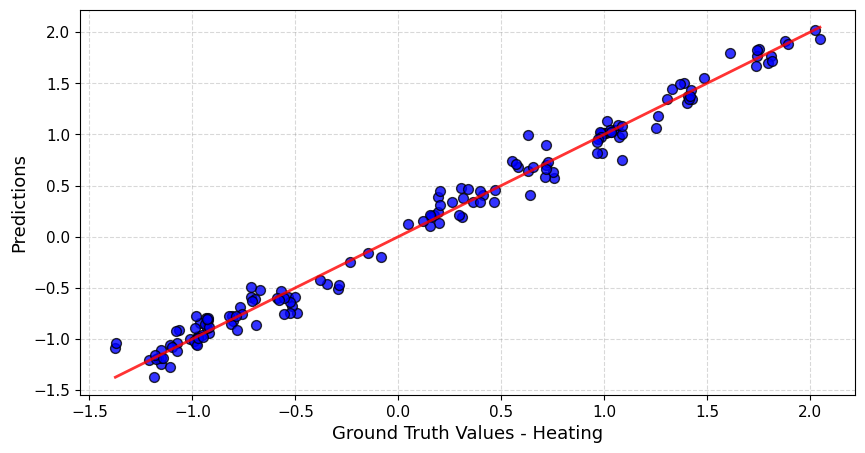

In [30]:
min_val = min(min(y_pred), min(y_true))
max_val = max(max(y_pred), max(y_true))

plt.figure(figsize=(10, 5))
plt.scatter(
    y_true, 
    y_pred, 
    alpha=0.8,
    color="blue",
    marker="o",
    edgecolor="black",
    s=50,
    label="Predictions",
)
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    label="Perfect Prediction",
    color="red",
    alpha=0.8,
    linewidth=2
)
plt.xlabel("Ground Truth Values - Heating")
plt.ylabel("Predictions")
plt.show()